# Regularization and Optimization of Neural Networks - Lab

## Introduction

Recall from the last lab that we had a training accuracy close to 90% and a test set accuracy close to 76%.

As with our previous machine learning work, we should be asking a couple of questions:
- Is there a high bias? yes/no
- Is there a high variance? yes/no

Also recall that "high bias" is a relative concept. Knowing we have 7 classes and the topics are related, we'll assume that a 90% accuracy is pretty good and the bias on the training set is low. (We've also discussed concepts like precision, recall as well as AUC and ROC curves.)   

In this lab, we'll use the notion of training/validation/test set to get better insights of how we can mitigate our variance, and we'll look at a few regularization techniques. You'll start by repeating the process from the last section: importing the data and performing preprocessing including one-hot encoding. Then, just before you go on to train the model, we'll introduce how to include a validation set. You'll then define and compile the model as before. This time, when you are presented with the `history` dictionary of the model, you will have additional data entries for not only the train and test, but the train, test and validation  and then defigning, compiling and training the model. 


## Objectives

You will be able to:

* Construct and run a basic model in Keras
* Construct a validation set and explain potential benefits
* Apply L1 and L2 regularization
* Aplly dropout regularization
* Observe and comment on the effect of using more data

## Import the libraries

As usual, start by importing some of the packages and modules that you intend to use. The first thing we'll be doing is importing the data and taking a random sample, so that should clue you in to what tools to import. If you need more tools down the line, you can always import additional packages later.

In [17]:
#Your code here; import some packages/modules you plan to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Load the Data

As with the previous lab, the data is stored in a file **Bank_complaints.csv**. Load and preview the dataset.

In [2]:
#Your code here; load and preview the dataset
df = pd.read_csv('Bank_complaints.csv')
df.head()

,Product,Consumer complaint narrative
0,Student loan,In XX/XX/XXXX I filled out the Fedlaon applica...
1,Student loan,I am being contacted by a debt collector for p...
2,Student loan,I cosigned XXXX student loans at SallieMae for...
3,Student loan,Navient has sytematically and illegally failed...
4,Student loan,My wife became eligible for XXXX Loan Forgiven...


## Preprocessing Overview

Before we begin to practice some of our new tools regarding regularization and optimization, let's practice munging some data as we did in the previous section with bank complaints. Recall some techniques:

* Sampling in order to reduce training time (investigate model accuracy vs data size later on)
* One-hot encoding our complaint text
* Transforming our category labels
* Train - test split

## Preprocessing: Generate a Random Sample

Since we have quite a bit of data and training networks takes a substantial amount of time and resources, we will downsample in order to test our initial pipeline. Going forward, these can be interesting areas of investigation: how does our models performance change as we increase (or decrease) the size of our dataset?  

Generate the random sample using seed 123 for consistency of results. Make your new sample have 10,000 observations.

In [7]:
#Your code here
random.seed(123)
df = df.sample(10000)
df.index = range(10000)
df.head()

,Product,Consumer complaint narrative
0,Consumer Loan,Due to an accident resulting in a total loss o...
1,Credit card,Capital One continues to list hidden charges f...
2,Mortgage,Nationstar Mortgage took over my loan in XXXX ...
3,Bank account or service,"Safe Deposit Box, of XXXX XXXX XXXX XXXX. \nXX..."
4,Student loan,XXXX XXXX XXXX XXXX XXXX XXXX issued a garnism...


In [9]:
product = df.Product
complaints = df["Consumer complaint narrative"]

In [11]:
complaints[:5]

0    Due to an accident resulting in a total loss o...
1    Capital One continues to list hidden charges f...
2    Nationstar Mortgage took over my loan in XXXX ...
3    Safe Deposit Box, of XXXX XXXX XXXX XXXX. \nXX...
4    XXXX XXXX XXXX XXXX XXXX XXXX issued a garnism...
Name: Consumer complaint narrative, dtype: object

## Preprocessing: One-hot Encoding of the Complaints

As before, we need to do some preprocessing and data manipulationg before building the neural network. Last time, we guided you through the process, and now its time for you to practice that pipeline independently.  

Only keep 2,000 most common words and use one-hot encoding to reformat the complaints into a matrix of vectors.

In [12]:
#Your code here; use one-hot encoding to reformat the complaints into a matrix of vectors.
#Only keep the 2000 most common words.
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints) 

one_hot_results = tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)


(10000, 2000)

In [21]:
type(word_index)

dict

## Preprocessing: Encoding the Products

Similarly, now transform the descriptive product labels to integers labels. After transforming them to integer labels, retransform them into a matrix of binary flags, one for each of the various product labels.  
  
  (Note: this is similar to our previous work with dummy variables: each of the various product categories will be its own column, and each observation will be a row. Each of these observation rows will have a 1 in the column associated with it's label, and all other entries for the row will be zero.)

In [15]:
#Your code here; transform the product labels to numerical values
#Then transform these integer values into a matrix of binary flags
le = LabelEncoder()
le.fit(product)
product_cat = le.transform(product)
product_cat

array([2, 3, 5, ..., 1, 2, 5])

In [16]:
product_onehot = to_categorical(product_cat)
product_onehot

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## Train-test Split

Now onto the ever familiar train-test split! Be sure to split both the complaint data (now transformed into word vectors) as well as their associated labels. Perform an appropriate train test split.

In [22]:
#Your code here
X_train, X_test, y_train, y_test = train_test_split(one_hot_results, product_onehot, test_size=1500, random_state=42)


## Running the model using a validation set.

## Creating the Validation Set

In the lecture we mentioned that in deep learning, we generally keep aside a validation set, which is used during hyperparameter tuning. Then when we have made the final model decision, the test set is used to define the final model perforance. 

In this example, let's take the first 1000 cases out of the training set to become the validation set. You should do this for both `train` and `label_train`.

In [23]:
#Just run this block of code 
random.seed(123)
val = X_train[:1000]
train_final = X_train[1000:]
label_val = y_train[:1000]
label_train_final = y_train[1000:]

In [32]:
label_val.shape

(1000, 7)

## Creating the Model

Let's rebuild a fully connected (Dense) layer network with relu activations in Keras.

Recall that we used 2 hidden with 50 units in the first layer and 25 in the second, both with a `relu` activation function. Because we are dealing with a multiclass problem (classifying the complaints into 7 classes), we use a use a softmax classifyer in order to output 7 class probabilities per case.  



In [40]:
#Your code here; build a neural network using Keras as described above.
from keras import models, layers, optimizers

model = models.Sequential()
model.add(layers.Dense(units=50, activation="relu", input_shape=(2000,)))
model.add(layers.Dense(units=25, activation="relu"))
model.add(layers.Dense(units=7, activation="softmax"))

## Compiling the Model
In the compiler, you'll be passing the optimizer, loss function, and metrics. Train the model for 120 epochs in mini-batches of 256 samples. This time, let's include the argument `validation_data` and assign it `(val, label_val)`

In [41]:
#Your code here
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [38]:
model.fit(train_final, label_train_final, batch_size=256, epochs=120, validation_data=(val, label_val))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 107us/step - loss: 1.9352 - acc: 0.1933 - val_loss: 1.9262 - val_acc: 0.1970
Epoch 2/120
7500/7500 [==============================] - 0s 57us/step - loss: 1.9096 - acc: 0.2221 - val_loss: 1.9042 - val_acc: 0.2240
Epoch 3/120
7500/7500 [==============================] - 0s 57us/step - loss: 1.8868 - acc: 0.2419 - val_loss: 1.8810 - val_acc: 0.2490
Epoch 4/120
7500/7500 [==============================] - 0s 60us/step - loss: 1.8604 - acc: 0.2685 - val_loss: 1.8528 - val_acc: 0.2690
Epoch 5/120
7500/7500 [==============================] - 1s 69us/step - loss: 1.8286 - acc: 0.3009 - val_loss: 1.8209 - val_acc: 0.3010
Epoch 6/120
7500/7500 [==============================] - 1s 67us/step - loss: 1.7926 - acc: 0.3196 - val_loss: 1.7829 - val_acc: 0.3240
Epoch 7/120
7500/7500 [=================

7500/7500 [==============================] - 0s 61us/step - loss: 0.5646 - acc: 0.8120 - val_loss: 0.6918 - val_acc: 0.7500
Epoch 57/120
7500/7500 [==============================] - 0s 54us/step - loss: 0.5588 - acc: 0.8149 - val_loss: 0.6903 - val_acc: 0.7450
Epoch 58/120
7500/7500 [==============================] - 0s 54us/step - loss: 0.5529 - acc: 0.8155 - val_loss: 0.6850 - val_acc: 0.7490
Epoch 59/120
7500/7500 [==============================] - 0s 53us/step - loss: 0.5465 - acc: 0.8187 - val_loss: 0.6839 - val_acc: 0.7520
Epoch 60/120
7500/7500 [==============================] - 0s 53us/step - loss: 0.5417 - acc: 0.8207 - val_loss: 0.6820 - val_acc: 0.7480
Epoch 61/120
7500/7500 [==============================] - 0s 64us/step - loss: 0.5362 - acc: 0.8220 - val_loss: 0.6791 - val_acc: 0.7540
Epoch 62/120
7500/7500 [==============================] - 0s 62us/step - loss: 0.5305 - acc: 0.8219 - val_loss: 0.6720 - val_acc: 0.7450
Epoch 63/120
7500/7500 [==============================

Epoch 116/120
7500/7500 [==============================] - 0s 66us/step - loss: 0.3439 - acc: 0.8928 - val_loss: 0.6389 - val_acc: 0.7640
Epoch 117/120
7500/7500 [==============================] - 1s 74us/step - loss: 0.3410 - acc: 0.8952 - val_loss: 0.6404 - val_acc: 0.7640
Epoch 118/120
7500/7500 [==============================] - 0s 64us/step - loss: 0.3393 - acc: 0.8957 - val_loss: 0.6423 - val_acc: 0.7630
Epoch 119/120
7500/7500 [==============================] - 0s 63us/step - loss: 0.3361 - acc: 0.8977 - val_loss: 0.6401 - val_acc: 0.7600
Epoch 120/120
7500/7500 [==============================] - 0s 59us/step - loss: 0.3342 - acc: 0.8981 - val_loss: 0.6374 - val_acc: 0.7660


## Part 2: Code Along

The remaining portion of this lab will introduce you to code snippets for a myriad of different methods discussed in the lecture.

## Training the Model

Ok, now for the resource intensive part: time to train our model! Note that this is where we also introduce the validation data to the model.

In [42]:
#Code provided; note the extra validation parameter passed.
model_val = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 100us/step - loss: 1.9437 - acc: 0.1560 - val_loss: 1.9279 - val_acc: 0.1740
Epoch 2/120
7500/7500 [==============================] - 0s 64us/step - loss: 1.9156 - acc: 0.1839 - val_loss: 1.9104 - val_acc: 0.1970
Epoch 3/120
7500/7500 [==============================] - 0s 63us/step - loss: 1.8970 - acc: 0.2055 - val_loss: 1.8944 - val_acc: 0.2040
Epoch 4/120
7500/7500 [==============================] - 0s 63us/step - loss: 1.8796 - acc: 0.2199 - val_loss: 1.8784 - val_acc: 0.2160
Epoch 5/120
7500/7500 [==============================] - 0s 63us/step - loss: 1.8618 - acc: 0.2239 - val_loss: 1.8609 - val_acc: 0.2240
Epoch 6/120
7500/7500 [==============================] - 1s 67us/step - loss: 1.8427 - acc: 0.2319 - val_loss: 1.8416 - val_acc: 0.2290
Epoch 7/120
7500/7500 [==============================] - 0s 65us/step - loss: 1.8217 - acc: 0.2401 - val_loss: 1.8201 - val_acc: 0.2440

Epoch 60/120
7500/7500 [==============================] - 0s 64us/step - loss: 0.5768 - acc: 0.7987 - val_loss: 0.6803 - val_acc: 0.7290
Epoch 61/120
7500/7500 [==============================] - 0s 61us/step - loss: 0.5715 - acc: 0.8004 - val_loss: 0.6796 - val_acc: 0.7300
Epoch 62/120
7500/7500 [==============================] - 0s 62us/step - loss: 0.5662 - acc: 0.7988 - val_loss: 0.6760 - val_acc: 0.7340
Epoch 63/120
7500/7500 [==============================] - 0s 63us/step - loss: 0.5606 - acc: 0.8029 - val_loss: 0.6733 - val_acc: 0.7360
Epoch 64/120
7500/7500 [==============================] - 1s 72us/step - loss: 0.5554 - acc: 0.8033 - val_loss: 0.6724 - val_acc: 0.7310
Epoch 65/120
7500/7500 [==============================] - 0s 64us/step - loss: 0.5509 - acc: 0.8029 - val_loss: 0.6681 - val_acc: 0.7320
Epoch 66/120
7500/7500 [==============================] - 1s 72us/step - loss: 0.5458 - acc: 0.8056 - val_loss: 0.6664 - val_acc: 0.7380
Epoch 67/120
7500/7500 [=================

7500/7500 [==============================] - 0s 64us/step - loss: 0.3709 - acc: 0.8763 - val_loss: 0.6373 - val_acc: 0.7560
Epoch 120/120
7500/7500 [==============================] - 0s 63us/step - loss: 0.3687 - acc: 0.8769 - val_loss: 0.6380 - val_acc: 0.7560


## Retrieving Performance Results: the `history` dictionary

The dictionary `history` contains four entries this time: one per metric that was being monitored during training and during validation.

In [43]:
model_val_dict = model_val.history
model_val_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [44]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 0s 39us/step


In [45]:
results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 39us/step


In [46]:
results_train

[0.3652195799748103, 0.8797333333333334]

In [47]:
results_test

[0.6327094724178314, 0.7653333331743876]

Note that the result isn't exactly the same as before. Note that this because the training set is slightly different! We remove 1000 instances for validation!

## Plotting the Results

Let's plot the result similarly to what we have done in the previous lab. This time though, let's include the training and the validation loss in the same plot. We'll do the same thing for the training and validation accuracy.

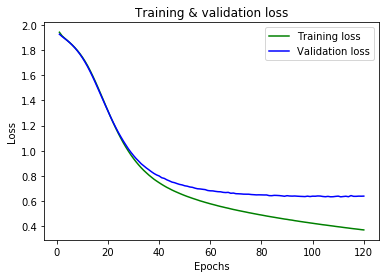

In [49]:
#plt.clf()

import matplotlib.pyplot as plt
loss_values = model_val_dict['loss']
val_loss_values = model_val_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

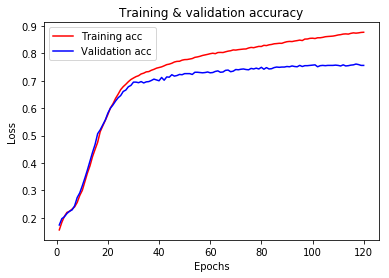

In [50]:
#plt.clf()

acc_values = model_val_dict['acc'] 
val_acc_values = model_val_dict['val_acc']

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'blue', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We observe an interesting pattern here: although the training accuracy keeps increasing when going through more epochs, and the training loss keeps decreasing, the validation accuracy and loss seem to be reaching a status quo around the 60th epoch. This means that we're actually **overfitting** to the train data when we do as many epochs as we were doing. Luckily, you learned how to tackle overfitting in the previous lecture! For starters, it does seem clear that we are training too long. So let's stop training at the 60th epoch first (so-called "early stopping") before we move to more advanced regularization techniques!

## Early Stopping

In [51]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model = model.fit(train_final,
                    label_train_final,
                    epochs=60,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/60
7500/7500 [==============================] - 1s 106us/step - loss: 1.9558 - acc: 0.1399 - val_loss: 1.9426 - val_acc: 0.1650
Epoch 2/60
7500/7500 [==============================] - 0s 59us/step - loss: 1.9241 - acc: 0.1936 - val_loss: 1.9188 - val_acc: 0.2100
Epoch 3/60
7500/7500 [==============================] - 0s 59us/step - loss: 1.9000 - acc: 0.2349 - val_loss: 1.8970 - val_acc: 0.2450
Epoch 4/60
7500/7500 [==============================] - 0s 60us/step - loss: 1.8770 - acc: 0.2684 - val_loss: 1.8755 - val_acc: 0.2680
Epoch 5/60
7500/7500 [==============================] - 0s 59us/step - loss: 1.8530 - acc: 0.2940 - val_loss: 1.8521 - val_acc: 0.2950
Epoch 6/60
7500/7500 [==============================] - 0s 57us/step - loss: 1.8268 - acc: 0.3167 - val_loss: 1.8258 - val_acc: 0.3250
Epoch 7/60
7500/7500 [==============================] - 0s 60us/step - loss: 1.7976 - acc: 0.3399 - val_loss: 1.7967 - val_acc: 0.3330
Epoch 

Now, you can use the test set to make label predictions

In [52]:
results_train = model.evaluate(train_final, label_train_final)

7500/7500 [==============================] - 0s 42us/step


In [53]:
results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 40us/step


In [54]:
results_train

[0.5414692291259766, 0.818]

In [55]:
results_test

[0.691273176908493, 0.7499999998410543]

We've significantly reduced the variance, so this is already pretty good! Our test set accuracy is slightly worse, but this model will definitely be more robust than the 120 epochs one we fitted before.

Now, let's see what else we can do to improve the result!

## L2 Regularization

Let's include L2 regularization. You can easily do this in keras adding the argument kernel_regulizers.l2 and adding a value for the regularization parameter lambda between parentheses.

In [56]:
from keras import regularizers
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L2_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 115us/step - loss: 2.5705 - acc: 0.1901 - val_loss: 2.5595 - val_acc: 0.1960
Epoch 2/120
7500/7500 [==============================] - 0s 61us/step - loss: 2.5409 - acc: 0.2221 - val_loss: 2.5336 - val_acc: 0.2340
Epoch 3/120
7500/7500 [==============================] - 0s 64us/step - loss: 2.5096 - acc: 0.2448 - val_loss: 2.5034 - val_acc: 0.2660
Epoch 4/120
7500/7500 [==============================] - 1s 72us/step - loss: 2.4753 - acc: 0.2668 - val_loss: 2.4693 - val_acc: 0.2750
Epoch 5/120
7500/7500 [==============================] - 0s 61us/step - loss: 2.4371 - acc: 0.2860 - val_loss: 2.4300 - val_acc: 0.3120
Epoch 6/120
7500/7500 [==============================] - 0s 64us/step - loss: 2.3962 - acc: 0.3152 - val_loss: 2.3885 - val_acc: 0.3220
Epoch 7/120
7500/7500 [==============================] - 0s 60us/step - loss: 2.3524 - acc: 0.3372 - val_loss: 2.3424 - val_acc: 0.3610

7500/7500 [==============================] - 0s 61us/step - loss: 1.1033 - acc: 0.8015 - val_loss: 1.2066 - val_acc: 0.7480
Epoch 61/120
7500/7500 [==============================] - 1s 70us/step - loss: 1.0968 - acc: 0.8068 - val_loss: 1.2012 - val_acc: 0.7390
Epoch 62/120
7500/7500 [==============================] - 1s 70us/step - loss: 1.0902 - acc: 0.8075 - val_loss: 1.1970 - val_acc: 0.7380
Epoch 63/120
7500/7500 [==============================] - 0s 64us/step - loss: 1.0843 - acc: 0.8097 - val_loss: 1.1947 - val_acc: 0.7370
Epoch 64/120
7500/7500 [==============================] - 1s 73us/step - loss: 1.0785 - acc: 0.8088 - val_loss: 1.1881 - val_acc: 0.7460
Epoch 65/120
7500/7500 [==============================] - 1s 71us/step - loss: 1.0722 - acc: 0.8113 - val_loss: 1.1847 - val_acc: 0.7420
Epoch 66/120
7500/7500 [==============================] - 0s 64us/step - loss: 1.0663 - acc: 0.8145 - val_loss: 1.1819 - val_acc: 0.7390
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 1s 68us/step - loss: 0.8353 - acc: 0.8772 - val_loss: 1.0489 - val_acc: 0.7650


In [57]:
L2_model_dict = L2_model.history
L2_model_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Let's look at the training accuracy as well as the validation accuracy for both the L2 and the model without regularization (for 120 epochs).

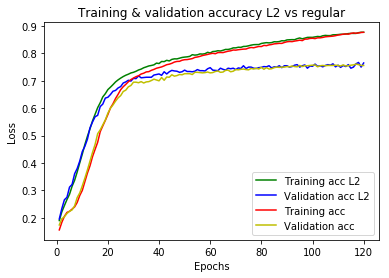

In [59]:
plt.clf()

acc_values = L2_model_dict['acc'] 
val_acc_values = L2_model_dict['val_acc']
model_acc = model_val_dict['acc']
model_val_acc = model_val_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L2')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc L2')
plt.plot(epochs, model_acc, 'r', label='Training acc')
plt.plot(epochs, model_val_acc, 'y', label='Validation acc')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results of L2 regularization are quite disappointing here. We notice the discrepancy between validation and training accuracy seems to have decreased slightly, but the end result is definitely not getting better. 

## L1 Regularization

Let's have a look at L1 regularization. Will this work better?

In [60]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/120
7500/7500 [==============================] - 1s 116us/step - loss: 15.9311 - acc: 0.1967 - val_loss: 15.5291 - val_acc: 0.1990
Epoch 2/120
7500/7500 [==============================] - 0s 54us/step - loss: 15.1681 - acc: 0.2193 - val_loss: 14.7798 - val_acc: 0.2120
Epoch 3/120
7500/7500 [==============================] - 0s 56us/step - loss: 14.4261 - acc: 0.2249 - val_loss: 14.0517 - val_acc: 0.2200
Epoch 4/120
7500/7500 [==============================] - 0s 56us/step - loss: 13.7058 - acc: 0.2364 - val_loss: 13.3440 - val_acc: 0.2340
Epoch 5/120
7500/7500 [==============================] - 0s 59us/step - loss: 13.0062 - acc: 0.2512 - val_loss: 12.6560 - val_acc: 0.2580
Epoch 6/120
7500/7500 [==============================] - 0s 60us/step - loss: 12.3259 - acc: 0.2713 - val_loss: 11.9866 - val_acc: 0.2930
Epoch 7/120
7500/7500 [==============================] - 0s 62us/step - loss: 11.6636 - acc: 0.3059 - val_loss: 11.3356 - v

7500/7500 [==============================] - 0s 59us/step - loss: 1.6891 - acc: 0.6971 - val_loss: 1.6939 - val_acc: 0.6760
Epoch 61/120
7500/7500 [==============================] - 0s 56us/step - loss: 1.6791 - acc: 0.6980 - val_loss: 1.6852 - val_acc: 0.6780
Epoch 62/120
7500/7500 [==============================] - 1s 68us/step - loss: 1.6695 - acc: 0.6980 - val_loss: 1.6768 - val_acc: 0.6760
Epoch 63/120
7500/7500 [==============================] - 1s 73us/step - loss: 1.6603 - acc: 0.6993 - val_loss: 1.6658 - val_acc: 0.6750
Epoch 64/120
7500/7500 [==============================] - 1s 70us/step - loss: 1.6508 - acc: 0.7004 - val_loss: 1.6586 - val_acc: 0.6660
Epoch 65/120
7500/7500 [==============================] - 0s 58us/step - loss: 1.6417 - acc: 0.7016 - val_loss: 1.6479 - val_acc: 0.6750
Epoch 66/120
7500/7500 [==============================] - 0s 58us/step - loss: 1.6325 - acc: 0.7009 - val_loss: 1.6406 - val_acc: 0.6770
Epoch 67/120
7500/7500 [==============================

Epoch 120/120
7500/7500 [==============================] - 0s 59us/step - loss: 1.2881 - acc: 0.7236 - val_loss: 1.3075 - val_acc: 0.6930


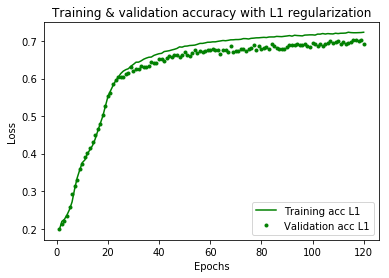

In [61]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'g.', label='Validation acc L1')
plt.title('Training & validation accuracy with L1 regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Notice how The training and validation accuracy don't diverge as much as before! Unfortunately, the validation accuracy doesn't reach rates much higher than 70%. It does seem like we can still improve the model by training much longer.

In [62]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

L1_model = model.fit(train_final,
                    label_train_final,
                    epochs=1000,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 7500 samples, validate on 1000 samples
Epoch 1/1000
7500/7500 [==============================] - 1s 129us/step - loss: 16.0209 - acc: 0.1444 - val_loss: 15.6098 - val_acc: 0.1680
Epoch 2/1000
7500/7500 [==============================] - 0s 59us/step - loss: 15.2521 - acc: 0.1859 - val_loss: 14.8609 - val_acc: 0.2110
Epoch 3/1000
7500/7500 [==============================] - 0s 60us/step - loss: 14.5113 - acc: 0.2215 - val_loss: 14.1344 - val_acc: 0.2520
Epoch 4/1000
7500/7500 [==============================] - 0s 63us/step - loss: 13.7918 - acc: 0.2571 - val_loss: 13.4265 - val_acc: 0.2850
Epoch 5/1000
7500/7500 [==============================] - 0s 62us/step - loss: 13.0906 - acc: 0.2903 - val_loss: 12.7364 - val_acc: 0.3080
Epoch 6/1000
7500/7500 [==============================] - 0s 63us/step - loss: 12.4078 - acc: 0.3244 - val_loss: 12.0651 - val_acc: 0.3330
Epoch 7/1000
7500/7500 [==============================] - 0s 62us/step - loss: 11.7447 - acc: 0.3557 - val_loss: 11.4

Epoch 60/1000
7500/7500 [==============================] - 1s 67us/step - loss: 1.7374 - acc: 0.6879 - val_loss: 1.7468 - val_acc: 0.6700
Epoch 61/1000
7500/7500 [==============================] - 1s 68us/step - loss: 1.7270 - acc: 0.6887 - val_loss: 1.7383 - val_acc: 0.6760
Epoch 62/1000
7500/7500 [==============================] - ETA: 0s - loss: 1.7125 - acc: 0.692 - 0s 64us/step - loss: 1.7175 - acc: 0.6895 - val_loss: 1.7321 - val_acc: 0.6740
Epoch 63/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.7083 - acc: 0.6901 - val_loss: 1.7194 - val_acc: 0.6620
Epoch 64/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.6984 - acc: 0.6903 - val_loss: 1.7124 - val_acc: 0.6660
Epoch 65/1000
7500/7500 [==============================] - 0s 54us/step - loss: 1.6892 - acc: 0.6915 - val_loss: 1.6995 - val_acc: 0.6750
Epoch 66/1000
7500/7500 [==============================] - 0s 54us/step - loss: 1.6795 - acc: 0.6917 - val_loss: 1.6967 - val_acc: 0.6

Epoch 119/1000
7500/7500 [==============================] - 0s 53us/step - loss: 1.3287 - acc: 0.7127 - val_loss: 1.3512 - val_acc: 0.6960
Epoch 120/1000
7500/7500 [==============================] - 0s 53us/step - loss: 1.3238 - acc: 0.7127 - val_loss: 1.3469 - val_acc: 0.6960
Epoch 121/1000
7500/7500 [==============================] - 0s 55us/step - loss: 1.3188 - acc: 0.7141 - val_loss: 1.3421 - val_acc: 0.6960
Epoch 122/1000
7500/7500 [==============================] - 0s 56us/step - loss: 1.3142 - acc: 0.7147 - val_loss: 1.3372 - val_acc: 0.6980
Epoch 123/1000
7500/7500 [==============================] - 0s 53us/step - loss: 1.3096 - acc: 0.7140 - val_loss: 1.3323 - val_acc: 0.6970
Epoch 124/1000
7500/7500 [==============================] - 0s 61us/step - loss: 1.3048 - acc: 0.7144 - val_loss: 1.3276 - val_acc: 0.6970
Epoch 125/1000
7500/7500 [==============================] - 0s 59us/step - loss: 1.3003 - acc: 0.7155 - val_loss: 1.3250 - val_acc: 0.7030
Epoch 126/1000
7500/7500 [=

Epoch 178/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.1193 - acc: 0.7313 - val_loss: 1.1593 - val_acc: 0.7140
Epoch 179/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.1165 - acc: 0.7304 - val_loss: 1.1554 - val_acc: 0.7120
Epoch 180/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.1147 - acc: 0.7308 - val_loss: 1.1509 - val_acc: 0.7140
Epoch 181/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.1119 - acc: 0.7313 - val_loss: 1.1516 - val_acc: 0.7200
Epoch 182/1000
7500/7500 [==============================] - 0s 59us/step - loss: 1.1099 - acc: 0.7332 - val_loss: 1.1479 - val_acc: 0.7170
Epoch 183/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.1079 - acc: 0.7331 - val_loss: 1.1477 - val_acc: 0.7160
Epoch 184/1000
7500/7500 [==============================] - 0s 62us/step - loss: 1.1060 - acc: 0.7336 - val_loss: 1.1431 - val_acc: 0.7160
Epoch 185/1000
7500/7500 [=

Epoch 237/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.0213 - acc: 0.7504 - val_loss: 1.0667 - val_acc: 0.7180
Epoch 238/1000
7500/7500 [==============================] - 0s 54us/step - loss: 1.0198 - acc: 0.7499 - val_loss: 1.0776 - val_acc: 0.7310
Epoch 239/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.0193 - acc: 0.7496 - val_loss: 1.0747 - val_acc: 0.7270
Epoch 240/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.0176 - acc: 0.7504 - val_loss: 1.0649 - val_acc: 0.7130
Epoch 241/1000
7500/7500 [==============================] - 0s 55us/step - loss: 1.0162 - acc: 0.7496 - val_loss: 1.0734 - val_acc: 0.7120
Epoch 242/1000
7500/7500 [==============================] - 0s 57us/step - loss: 1.0154 - acc: 0.7513 - val_loss: 1.0628 - val_acc: 0.7320
Epoch 243/1000
7500/7500 [==============================] - 0s 58us/step - loss: 1.0138 - acc: 0.7499 - val_loss: 1.0593 - val_acc: 0.7240
Epoch 244/1000
7500/7500 [=

Epoch 296/1000
7500/7500 [==============================] - 0s 66us/step - loss: 0.9648 - acc: 0.7625 - val_loss: 1.0147 - val_acc: 0.7260
Epoch 297/1000
7500/7500 [==============================] - 1s 70us/step - loss: 0.9637 - acc: 0.7615 - val_loss: 1.0154 - val_acc: 0.7330
Epoch 298/1000
7500/7500 [==============================] - 1s 67us/step - loss: 0.9626 - acc: 0.7617 - val_loss: 1.0197 - val_acc: 0.7300
Epoch 299/1000
7500/7500 [==============================] - 1s 73us/step - loss: 0.9624 - acc: 0.7636 - val_loss: 1.0165 - val_acc: 0.7340
Epoch 300/1000
7500/7500 [==============================] - 1s 72us/step - loss: 0.9608 - acc: 0.7639 - val_loss: 1.0160 - val_acc: 0.7290
Epoch 301/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.9604 - acc: 0.7629 - val_loss: 1.0124 - val_acc: 0.7200
Epoch 302/1000
7500/7500 [==============================] - 0s 59us/step - loss: 0.9598 - acc: 0.7627 - val_loss: 1.0206 - val_acc: 0.7380
Epoch 303/1000
7500/7500 [=

Epoch 355/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.9271 - acc: 0.7701 - val_loss: 0.9867 - val_acc: 0.7400
Epoch 356/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.9268 - acc: 0.7701 - val_loss: 1.0038 - val_acc: 0.7200
Epoch 357/1000
7500/7500 [==============================] - 0s 58us/step - loss: 0.9262 - acc: 0.7709 - val_loss: 0.9891 - val_acc: 0.7390
Epoch 358/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.9257 - acc: 0.7705 - val_loss: 0.9864 - val_acc: 0.7310
Epoch 359/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.9241 - acc: 0.7717 - val_loss: 0.9826 - val_acc: 0.7360
Epoch 360/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.9243 - acc: 0.7696 - val_loss: 1.0087 - val_acc: 0.7290
Epoch 361/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.9240 - acc: 0.7712 - val_loss: 0.9807 - val_acc: 0.7310
Epoch 362/1000
7500/7500 [=

Epoch 414/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8989 - acc: 0.7749 - val_loss: 0.9661 - val_acc: 0.7340
Epoch 415/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8987 - acc: 0.7780 - val_loss: 0.9809 - val_acc: 0.7410
Epoch 416/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8989 - acc: 0.7768 - val_loss: 0.9663 - val_acc: 0.7450
Epoch 417/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8978 - acc: 0.7757 - val_loss: 0.9615 - val_acc: 0.7340
Epoch 418/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8967 - acc: 0.7765 - val_loss: 0.9628 - val_acc: 0.7390
Epoch 419/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8971 - acc: 0.7761 - val_loss: 0.9639 - val_acc: 0.7380
Epoch 420/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8974 - acc: 0.7765 - val_loss: 0.9595 - val_acc: 0.7390
Epoch 421/1000
7500/7500 [=

Epoch 473/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8768 - acc: 0.7824 - val_loss: 0.9439 - val_acc: 0.7410
Epoch 474/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8756 - acc: 0.7821 - val_loss: 0.9499 - val_acc: 0.7480
Epoch 475/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8760 - acc: 0.7835 - val_loss: 0.9503 - val_acc: 0.7390
Epoch 476/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8749 - acc: 0.7809 - val_loss: 0.9607 - val_acc: 0.7420
Epoch 477/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8754 - acc: 0.7815 - val_loss: 0.9652 - val_acc: 0.7460
Epoch 478/1000
7500/7500 [==============================] - 0s 62us/step - loss: 0.8758 - acc: 0.7813 - val_loss: 0.9430 - val_acc: 0.7420
Epoch 479/1000
7500/7500 [==============================] - 0s 61us/step - loss: 0.8758 - acc: 0.7796 - val_loss: 0.9478 - val_acc: 0.7420
Epoch 480/1000
7500/7500 [=

Epoch 532/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8599 - acc: 0.7871 - val_loss: 0.9376 - val_acc: 0.7490
Epoch 533/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8575 - acc: 0.7873 - val_loss: 0.9400 - val_acc: 0.7510
Epoch 534/1000
7500/7500 [==============================] - 0s 65us/step - loss: 0.8587 - acc: 0.7884 - val_loss: 0.9334 - val_acc: 0.7490
Epoch 535/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8594 - acc: 0.7863 - val_loss: 0.9334 - val_acc: 0.7460
Epoch 536/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8594 - acc: 0.7863 - val_loss: 0.9436 - val_acc: 0.7450
Epoch 537/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8577 - acc: 0.7885 - val_loss: 0.9609 - val_acc: 0.7500
Epoch 538/1000
7500/7500 [==============================] - 0s 57us/step - loss: 0.8599 - acc: 0.7888 - val_loss: 0.9356 - val_acc: 0.7460
Epoch 539/1000
7500/7500 [=

Epoch 591/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8448 - acc: 0.7931 - val_loss: 0.9400 - val_acc: 0.7540
Epoch 592/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8453 - acc: 0.7893 - val_loss: 0.9246 - val_acc: 0.7460
Epoch 593/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8441 - acc: 0.7929 - val_loss: 0.9292 - val_acc: 0.7520
Epoch 594/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8453 - acc: 0.7908 - val_loss: 0.9359 - val_acc: 0.7590
Epoch 595/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8449 - acc: 0.7913 - val_loss: 0.9310 - val_acc: 0.7540
Epoch 596/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8436 - acc: 0.7917 - val_loss: 0.9239 - val_acc: 0.7490
Epoch 597/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8422 - acc: 0.7929 - val_loss: 0.9466 - val_acc: 0.7410
Epoch 598/1000
7500/7500 [=

Epoch 650/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8318 - acc: 0.7953 - val_loss: 0.9275 - val_acc: 0.7560
Epoch 651/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8324 - acc: 0.7949 - val_loss: 0.9339 - val_acc: 0.7560
Epoch 652/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8310 - acc: 0.7973 - val_loss: 0.9295 - val_acc: 0.7540
Epoch 653/1000
7500/7500 [==============================] - 0s 54us/step - loss: 0.8314 - acc: 0.7971 - val_loss: 0.9199 - val_acc: 0.7580
Epoch 654/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8299 - acc: 0.7988 - val_loss: 0.9335 - val_acc: 0.7540
Epoch 655/1000
7500/7500 [==============================] - 0s 56us/step - loss: 0.8307 - acc: 0.7969 - val_loss: 0.9528 - val_acc: 0.7490
Epoch 656/1000
7500/7500 [==============================] - 0s 55us/step - loss: 0.8314 - acc: 0.7965 - val_loss: 0.9177 - val_acc: 0.7510
Epoch 657/1000
7500/7500 [=

Epoch 709/1000
7500/7500 [==============================] - 1s 76us/step - loss: 0.8203 - acc: 0.7995 - val_loss: 0.9178 - val_acc: 0.7610
Epoch 710/1000
7500/7500 [==============================] - 1s 71us/step - loss: 0.8201 - acc: 0.8007 - val_loss: 0.9167 - val_acc: 0.7550
Epoch 711/1000
7500/7500 [==============================] - 1s 72us/step - loss: 0.8215 - acc: 0.8028 - val_loss: 0.9411 - val_acc: 0.7510
Epoch 712/1000
7500/7500 [==============================] - 1s 71us/step - loss: 0.8201 - acc: 0.8015 - val_loss: 0.9125 - val_acc: 0.7580
Epoch 713/1000
7500/7500 [==============================] - 1s 69us/step - loss: 0.8203 - acc: 0.8029 - val_loss: 0.9207 - val_acc: 0.7530
Epoch 714/1000
7500/7500 [==============================] - 1s 74us/step - loss: 0.8202 - acc: 0.8032 - val_loss: 0.9158 - val_acc: 0.7580
Epoch 715/1000
7500/7500 [==============================] - 1s 72us/step - loss: 0.8246 - acc: 0.7997 - val_loss: 0.9253 - val_acc: 0.7540
Epoch 716/1000
7500/7500 [=

Epoch 768/1000
7500/7500 [==============================] - 1s 81us/step - loss: 0.8133 - acc: 0.8045 - val_loss: 0.9171 - val_acc: 0.7570
Epoch 769/1000
7500/7500 [==============================] - 1s 78us/step - loss: 0.8114 - acc: 0.8057 - val_loss: 0.9346 - val_acc: 0.7520
Epoch 770/1000
7500/7500 [==============================] - 1s 83us/step - loss: 0.8132 - acc: 0.8023 - val_loss: 0.9214 - val_acc: 0.7560
Epoch 771/1000
7500/7500 [==============================] - 1s 70us/step - loss: 0.8115 - acc: 0.8036 - val_loss: 0.9209 - val_acc: 0.7550
Epoch 772/1000
7500/7500 [==============================] - 1s 78us/step - loss: 0.8125 - acc: 0.8027 - val_loss: 0.9427 - val_acc: 0.7330
Epoch 773/1000
7500/7500 [==============================] - 1s 68us/step - loss: 0.8125 - acc: 0.8029 - val_loss: 0.9266 - val_acc: 0.7480
Epoch 774/1000
7500/7500 [==============================] - 1s 77us/step - loss: 0.8163 - acc: 0.8055 - val_loss: 0.9359 - val_acc: 0.7430
Epoch 775/1000
7500/7500 [=

7500/7500 [==============================] - 1s 85us/step - loss: 0.8058 - acc: 0.8093 - val_loss: 0.9208 - val_acc: 0.7550
Epoch 827/1000
7500/7500 [==============================] - 1s 84us/step - loss: 0.8053 - acc: 0.8083 - val_loss: 0.9186 - val_acc: 0.7520
Epoch 828/1000
7500/7500 [==============================] - 1s 68us/step - loss: 0.8103 - acc: 0.8057 - val_loss: 0.9089 - val_acc: 0.7610A: 0s - loss: 0.8111 - acc: 0.805
Epoch 829/1000
7500/7500 [==============================] - 1s 83us/step - loss: 0.8057 - acc: 0.8112 - val_loss: 0.9287 - val_acc: 0.7470
Epoch 830/1000
7500/7500 [==============================] - 1s 73us/step - loss: 0.8055 - acc: 0.8105 - val_loss: 0.9259 - val_acc: 0.7500
Epoch 831/1000
7500/7500 [==============================] - 1s 83us/step - loss: 0.8052 - acc: 0.8073 - val_loss: 0.9410 - val_acc: 0.7430
Epoch 832/1000
7500/7500 [==============================] - 1s 78us/step - loss: 0.8044 - acc: 0.8076 - val_loss: 0.9190 - val_acc: 0.7610
Epoch 833

Epoch 885/1000
7500/7500 [==============================] - 1s 69us/step - loss: 0.8013 - acc: 0.8113 - val_loss: 0.9305 - val_acc: 0.7480
Epoch 886/1000
7500/7500 [==============================] - 1s 67us/step - loss: 0.8030 - acc: 0.8093 - val_loss: 0.9095 - val_acc: 0.7610
Epoch 887/1000
7500/7500 [==============================] - 1s 69us/step - loss: 0.7998 - acc: 0.8121 - val_loss: 0.9268 - val_acc: 0.7570
Epoch 888/1000
7500/7500 [==============================] - 1s 68us/step - loss: 0.7971 - acc: 0.8123 - val_loss: 0.9294 - val_acc: 0.7520
Epoch 889/1000
7500/7500 [==============================] - 1s 69us/step - loss: 0.7990 - acc: 0.8112 - val_loss: 0.9051 - val_acc: 0.7610
Epoch 890/1000
7500/7500 [==============================] - 1s 68us/step - loss: 0.8002 - acc: 0.8089 - val_loss: 0.9133 - val_acc: 0.7570
Epoch 891/1000
7500/7500 [==============================] - 1s 67us/step - loss: 0.7996 - acc: 0.8113 - val_loss: 0.9128 - val_acc: 0.7540
Epoch 892/1000
7500/7500 [=

Epoch 944/1000
7500/7500 [==============================] - 0s 65us/step - loss: 0.7940 - acc: 0.8136 - val_loss: 0.9080 - val_acc: 0.7560
Epoch 945/1000
7500/7500 [==============================] - 0s 65us/step - loss: 0.7925 - acc: 0.8147 - val_loss: 0.9057 - val_acc: 0.7580
Epoch 946/1000
7500/7500 [==============================] - 0s 63us/step - loss: 0.7971 - acc: 0.8148 - val_loss: 0.9345 - val_acc: 0.7540
Epoch 947/1000
7500/7500 [==============================] - 0s 64us/step - loss: 0.7921 - acc: 0.8140 - val_loss: 0.9401 - val_acc: 0.7510
Epoch 948/1000
7500/7500 [==============================] - 0s 66us/step - loss: 0.7932 - acc: 0.8189 - val_loss: 0.9154 - val_acc: 0.7570
Epoch 949/1000
7500/7500 [==============================] - 0s 66us/step - loss: 0.7902 - acc: 0.8173 - val_loss: 0.9021 - val_acc: 0.7660
Epoch 950/1000
7500/7500 [==============================] - 0s 66us/step - loss: 0.7934 - acc: 0.8157 - val_loss: 0.9099 - val_acc: 0.7540
Epoch 951/1000
7500/7500 [=

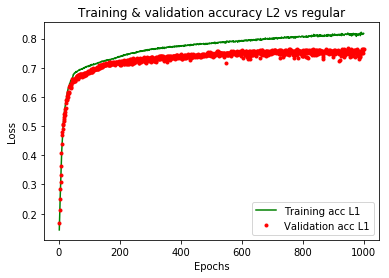

In [63]:
L1_model_dict = L1_model.history
plt.clf()

acc_values = L1_model_dict['acc'] 
val_acc_values = L1_model_dict['val_acc']

epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'g', label='Training acc L1')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc L1')
plt.title('Training & validation accuracy L2 vs regular')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [64]:
results_train = model.evaluate(train_final, label_train_final)

results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 51us/step


In [65]:
results_train

[0.7771187589327494, 0.8226666666984558]

In [66]:
results_test

[0.9170150950749715, 0.7619999998410543]

This is about the best we've seen so far, but we were training for quite a while! Let's see if dropout regularization can do even better and/or be more efficient!

## Dropout Regularization

In [67]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dropout(0.3, input_shape=(2000,)))
model.add(layers.Dense(50, activation='relu')) #2 hidden layers
model.add(layers.Dropout(0.3))
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

dropout_model = model.fit(train_final,
                    label_train_final,
                    epochs=200,
                    batch_size=256,
                    validation_data=(val, label_val))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 7500 samples, validate on 1000 samples
Epoch 1/200
7500/7500 [==============================] - 1s 190us/step - loss: 1.9826 - acc: 0.1400 - val_loss: 1.9484 - val_acc: 0.1610
Epoch 2/200
7500/7500 [==============================] - 1s 106us/step - loss: 1.9543 - acc: 0.1607 - val_loss: 1.9343 - val_acc: 0.1910
Epoch 3/200
7500/7500 [==============================] - 1s 98us/step - loss: 1.9371 - acc: 0.1756 - val_loss: 1.9241 - val_acc: 0.2010
Epoch 4/200
7500/7500 [==============================] - 1s 98us/step - loss: 1.9290 - acc: 0.1829 - val_loss: 1.9155 - val_acc: 0.2140
Epoch 5/200
7500/7500 [==============================] - 1s 93us/step - loss: 1.9183 - acc: 0.1960 - val_loss: 1.9070 - val_acc: 0.2270
Epoch 6/200
7500/7500 [==============================] - 1s 91us/step - loss: 1.9086 - acc: 0.2041 - val_loss: 1.8977 - val_acc: 0.2320
Epoch 7/200
7500/75

Epoch 58/200
7500/7500 [==============================] - 1s 107us/step - loss: 1.2211 - acc: 0.5369 - val_loss: 1.0097 - val_acc: 0.6960
Epoch 59/200
7500/7500 [==============================] - 1s 94us/step - loss: 1.2247 - acc: 0.5348 - val_loss: 0.9991 - val_acc: 0.6980
Epoch 60/200
7500/7500 [==============================] - 1s 90us/step - loss: 1.2161 - acc: 0.5412 - val_loss: 0.9915 - val_acc: 0.6940
Epoch 61/200
7500/7500 [==============================] - 1s 110us/step - loss: 1.2011 - acc: 0.5496 - val_loss: 0.9817 - val_acc: 0.6990
Epoch 62/200
7500/7500 [==============================] - 1s 101us/step - loss: 1.2014 - acc: 0.5515 - val_loss: 0.9756 - val_acc: 0.6980
Epoch 63/200
7500/7500 [==============================] - 1s 102us/step - loss: 1.1914 - acc: 0.5467 - val_loss: 0.9642 - val_acc: 0.7040
Epoch 64/200
7500/7500 [==============================] - 1s 106us/step - loss: 1.1785 - acc: 0.5596 - val_loss: 0.9548 - val_acc: 0.7050
Epoch 65/200
7500/7500 [============

7500/7500 [==============================] - ETA: 0s - loss: 0.9211 - acc: 0.664 - 1s 94us/step - loss: 0.9215 - acc: 0.6641 - val_loss: 0.7129 - val_acc: 0.7490
Epoch 118/200
7500/7500 [==============================] - 1s 91us/step - loss: 0.9234 - acc: 0.6608 - val_loss: 0.7122 - val_acc: 0.7490
Epoch 119/200
7500/7500 [==============================] - 1s 94us/step - loss: 0.9278 - acc: 0.6601 - val_loss: 0.7091 - val_acc: 0.7520
Epoch 120/200
7500/7500 [==============================] - 1s 90us/step - loss: 0.9167 - acc: 0.6543 - val_loss: 0.7066 - val_acc: 0.7510
Epoch 121/200
7500/7500 [==============================] - 1s 89us/step - loss: 0.9059 - acc: 0.6635 - val_loss: 0.7028 - val_acc: 0.7510
Epoch 122/200
7500/7500 [==============================] - 1s 90us/step - loss: 0.9064 - acc: 0.6613 - val_loss: 0.7022 - val_acc: 0.7520
Epoch 123/200
7500/7500 [==============================] - 1s 91us/step - loss: 0.9084 - acc: 0.6641 - val_loss: 0.6994 - val_acc: 0.7530
Epoch 124/

7500/7500 [==============================] - 1s 88us/step - loss: 0.7851 - acc: 0.6995 - val_loss: 0.6276 - val_acc: 0.7610
Epoch 177/200
7500/7500 [==============================] - 1s 88us/step - loss: 0.7851 - acc: 0.7057 - val_loss: 0.6287 - val_acc: 0.7640
Epoch 178/200
7500/7500 [==============================] - 1s 87us/step - loss: 0.7856 - acc: 0.7108 - val_loss: 0.6264 - val_acc: 0.7620
Epoch 179/200
7500/7500 [==============================] - 1s 85us/step - loss: 0.7879 - acc: 0.7024 - val_loss: 0.6268 - val_acc: 0.7640
Epoch 180/200
7500/7500 [==============================] - 1s 86us/step - loss: 0.7730 - acc: 0.7141 - val_loss: 0.6257 - val_acc: 0.7660
Epoch 181/200
7500/7500 [==============================] - 1s 88us/step - loss: 0.7802 - acc: 0.7096 - val_loss: 0.6231 - val_acc: 0.7660
Epoch 182/200
7500/7500 [==============================] - 1s 90us/step - loss: 0.7790 - acc: 0.7081 - val_loss: 0.6231 - val_acc: 0.7660
Epoch 183/200
7500/7500 [=======================

In [68]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(X_test, y_test)

1500/1500 [==============================] - 0s 49us/step


In [69]:
results_train

[0.47081585088570915, 0.8266666666984558]

In [70]:
results_test

[0.6240548561414083, 0.7639999995231629]

You can see here that the validation performance has improved again! the variance did become higher again compared to L1-regularization.

## Bigger Data?

In the lecture, one of the solutions to high variance was just getting more data. We actually *have* more data, but took a subset of 10,000 units before. Let's now quadruple our data set, and see what happens. Note that we are really just lucky here, and getting more data isn't always possible, but this is a useful exercise in order to understand the power of big data sets.

In [72]:
df = pd.read_csv('Bank_complaints.csv')
random.seed(123)
df = df.sample(40000)
df.index = range(40000)
product = df["Product"]
complaints = df["Consumer complaint narrative"]

#one-hot encoding of the complaints
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(complaints)
sequences = tokenizer.texts_to_sequences(complaints)
one_hot_results= tokenizer.texts_to_matrix(complaints, mode='binary')
word_index = tokenizer.word_index
np.shape(one_hot_results)

#one-hot encoding of products
le = LabelEncoder()
le.fit(product)
list(le.classes_)
product_cat = le.transform(product) 
product_onehot = to_categorical(product_cat)

# train test split
test_index = random.sample(range(1,40000), 4000)
test = one_hot_results[test_index]
train = np.delete(one_hot_results, test_index, 0)
label_test = product_onehot[test_index]
label_train = np.delete(product_onehot, test_index, 0)

#Validation set
random.seed(123)
val = train[:3000]
train_final = train[3000:]
label_val = label_train[:3000]
label_train_final = label_train[3000:]

In [73]:
random.seed(123)
model = models.Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(2000,))) #2 hidden layers
model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

moredata_model = model.fit(train_final,
                    label_train_final,
                    epochs=120,
                    batch_size=256,
                    validation_data=(val, label_val))

Train on 33000 samples, validate on 3000 samples
Epoch 1/120
33000/33000 [==============================] - 2s 71us/step - loss: 1.9052 - acc: 0.1929 - val_loss: 1.8708 - val_acc: 0.2233
Epoch 2/120
33000/33000 [==============================] - 2s 49us/step - loss: 1.8199 - acc: 0.2702 - val_loss: 1.7655 - val_acc: 0.3320
Epoch 3/120
33000/33000 [==============================] - 2s 54us/step - loss: 1.6846 - acc: 0.3905 - val_loss: 1.5963 - val_acc: 0.4557
Epoch 4/120
33000/33000 [==============================] - 2s 50us/step - loss: 1.4988 - acc: 0.5019 - val_loss: 1.3930 - val_acc: 0.5587
Epoch 5/120
33000/33000 [==============================] - 2s 54us/step - loss: 1.3038 - acc: 0.5838 - val_loss: 1.2064 - val_acc: 0.6160
Epoch 6/120
33000/33000 [==============================] - 2s 50us/step - loss: 1.1391 - acc: 0.6375 - val_loss: 1.0640 - val_acc: 0.6470
Epoch 7/120
33000/33000 [==============================] - 2s 50us/step - loss: 1.0124 - acc: 0.6708 - val_loss: 0.9547 - v

33000/33000 [==============================] - 2s 53us/step - loss: 0.4091 - acc: 0.8575 - val_loss: 0.5431 - val_acc: 0.8030
Epoch 60/120
33000/33000 [==============================] - 2s 49us/step - loss: 0.4069 - acc: 0.8588 - val_loss: 0.5440 - val_acc: 0.8010
Epoch 61/120
33000/33000 [==============================] - 2s 48us/step - loss: 0.4045 - acc: 0.8598 - val_loss: 0.5410 - val_acc: 0.8023
Epoch 62/120
33000/33000 [==============================] - 2s 48us/step - loss: 0.4019 - acc: 0.8596 - val_loss: 0.5449 - val_acc: 0.8023
Epoch 63/120
33000/33000 [==============================] - 2s 49us/step - loss: 0.4000 - acc: 0.8618 - val_loss: 0.5468 - val_acc: 0.7997
Epoch 64/120
33000/33000 [==============================] - 2s 49us/step - loss: 0.3976 - acc: 0.8625 - val_loss: 0.5440 - val_acc: 0.8020
Epoch 65/120
33000/33000 [==============================] - 2s 49us/step - loss: 0.3953 - acc: 0.8627 - val_loss: 0.5464 - val_acc: 0.8043
Epoch 66/120
33000/33000 [==============

Epoch 118/120
33000/33000 [==============================] - 2s 53us/step - loss: 0.3130 - acc: 0.8931 - val_loss: 0.5933 - val_acc: 0.8037
Epoch 119/120
33000/33000 [==============================] - 2s 54us/step - loss: 0.3117 - acc: 0.8926 - val_loss: 0.5914 - val_acc: 0.8037
Epoch 120/120
33000/33000 [==============================] - 2s 53us/step - loss: 0.3107 - acc: 0.8928 - val_loss: 0.5914 - val_acc: 0.8047


In [74]:
results_train = model.evaluate(train_final, label_train_final)
results_test = model.evaluate(test, label_test)

4000/4000 [==============================] - 0s 49us/step


In [75]:
results_train

[0.30549447350068526, 0.8967272727272727]

In [76]:
results_test

[0.5640837223529815, 0.81075]

With the same amount of epochs, we were able to get a fairly similar validation accuracy of 89.67 (compared to 88.55 in obtained in the first model in this lab). Our test set accuracy went up from 75.8 to a staggering 80.225% though, without any other regularization technique. You can still consider early stopping, L1, L2 and dropout here. It's clear that having more data has a strong impact on model performance!

## Additional Resources

* https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Consumer_complaints.ipynb
* https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
* https://catalog.data.gov/dataset/consumer-complaint-database

## Summary  

In this lesson, we not only built an initial deep-learning model, we then used a validation set to tune our model using various types of regularization. From here, we'll continue to describe more practice and theory regarding tuning and optimizing deep-learning networks.